In [4]:
include("JULIA/alma.jl");
using Plots
using LaTeXStrings

In [5]:
# Set the number of digits for the arbitrary precision arithmetic

setprecision(128, base=10);

### Tidal deformation of Enceladus

Here I set up some models of tidal deformation of Enceladus following Beuthe 2018. I assume:
* a uniform, elastic inner core
* a global ocean
* an icy shell

Some general parameters:

In [6]:
a = 252e3;     # radius
c = 192e3;     # core radius

rho_i = 930;   # ice density
rho_w = 1020;  # water density
rho_b = 1610;  # bulk density

mu_i  = 3.5e9; # ice rigidity
mu_c  = 40e9;  # core rigidity

eta_w = 1e4;   # water viscosity

eta_m = 1e13;  # basal ice viscosity

Tm = 273;      # basal temperature
Ts = 59;       # surface temperature

Ea = 59.4e3;   # Activation energy (J/mol)
Rg = 8.314;    # gas constant (J/(mol*K))

omega = 5.307e-5;   # Rotation rate (s**-1)

mass      = rho_b * (4/3) * pi * a^3;     # Mass (kg)

Forcing period

In [7]:
t_sec  = 2*pi/omega;
t_days = t_sec / (24*60*60);
t_kyr  = t_days / (365.25 * 1000);

Range of ice thicknesses

In [8]:
h_ice=collect( (10:50)*1000 );

Some general parameters for ALMA

In [9]:
n = 2;
loadtype="tidal";
loadfcn="step";
tau=0;
order=8;

I. Elastic LNs as a function of the shell thickness (to be compared with FIG1 of Beuthe 2018)

In [10]:
@time begin

h_ela = zeros( length(h_ice) );
l_ela = zeros( length(h_ice) );
k_ela = zeros( length(h_ice) );

output="real";

t_elastic = 1e-9;

for i =1:length(h_ice)
    h       = h_ice[i];
    rb      = a - h;
    mass_ice   = 4/3 * pi * (a^3 - rb^3) * rho_i;
    mass_ocean = 4/3 * pi * (rb^3 - c^3) * rho_w;
    mass_core = mass - mass_ice - mass_ocean;
    rho_c     = mass_core / (4/3 * pi * c^3); 
    r         = [c, rb, a];
    rho       = [rho_c, rho_w, rho_i];
    mu        = [mu_c,  0,     mu_i];
    eta       = [1e99, eta_w,  eta_m];
    rheology  = ["elastic", "newton", "maxwell"];
    par       = zeros( (3,2) );
    model     = build_model(r,rho,mu,eta,rheology,par);
    hh, ll, kk = love_numbers(model, [ n ],[ t_elastic ],loadtype,loadfcn,tau,output,order);
    h_ela[i] = hh[1,1];
    l_ela[i] = ll[1,1];
    k_ela[i] = kk[1,1];
end

end


  8.876444 seconds (32.55 M allocations: 1.773 GiB, 7.56% gc time, 81.95% compilation time)


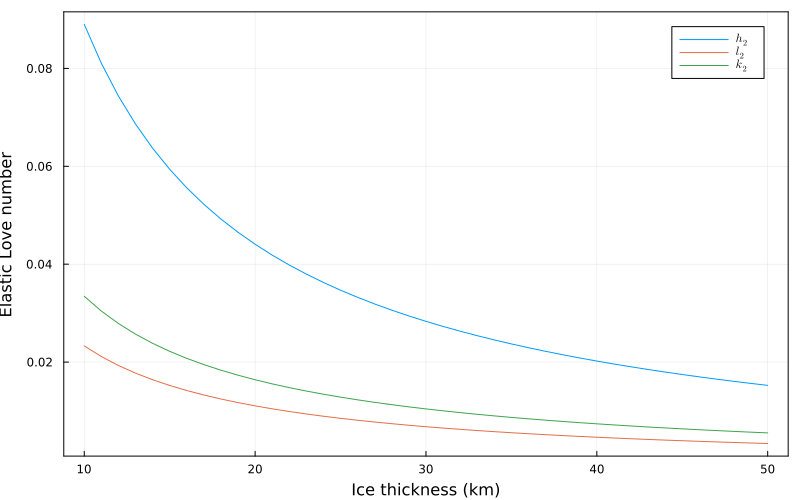

In [11]:
plot(  h_ice/1000, h_ela, framestyle=:box, label=L"h_2", size=(800,500) )
plot!( h_ice/1000, l_ela, framestyle=:box, label=L"l_2" )
plot!( h_ice/1000, k_ela, framestyle=:box, label=L"k_2" )
xlabel!( "Ice thickness (km)" )
ylabel!( "Elastic Love number" )

II. Viscoelastic LNs for a layered ice shell

Now I assume a temperature-dependent viscosity profile in the ice shell according to the Arrhenius law

$$ \eta = \eta_m \exp\left( \frac{E_a}{R_g T_m} \left[\frac{T_m}{T}-1\right) \right] $$

where $\eta_m$ is the ice melt viscosity, $R_g$ is the gas constant and $E_a = 59.4$ kJ/mol is the activation energy.

I assume that the base of the lithosphere has a basal temperature $T_m = 273K$ (to be in equilibrium with the liquid ocean) and that the surface has an average temperature $T_s = 59K$. The temperature $T$ inside the ice shell is assumed to scale with radius $r$ as

$$ T(r) = T_m^{(r-a)/(r_b-a)}  T_s^{(r_b-r)/(r_b-a)} $$

For a given ice shell thickness I create an onion-like structure with layers of constant thickness $\Delta$ and assign to each layer a viscosity given by the above equations.

In [12]:
@time begin

delta = 500;        # Layer size (m)

h_enc = zeros( Complex, length(h_ice) );
l_enc = zeros( Complex, length(h_ice) );
k_enc = zeros( Complex, length(h_ice) );

output="complex";

for i=1:length(h_ice)
    h       = h_ice[i];
    rb      = a - h;
    mass_ice   = 4/3 * pi * (a^3 - rb^3) * rho_i;
    mass_ocean = 4/3 * pi * (rb^3 - c^3) * rho_w;
    mass_core = mass - mass_ice - mass_ocean;
    rho_c     = mass_core / (4/3 * pi * c^3); 
    n_ice     = Int(round( h/delta ));
    r_ice     = collect( range(rb,a,length=n_ice+1) );
    x         = r_ice[1:end-1] .+ delta/2;
    T         = Tm.^( (x.-a)/(rb-a) ) .* Ts.^( (rb.-x) / (rb-a) );
    eta_ice   = eta_m * exp.( Ea ./ (Rg .* Tm) .* (Tm./T .- 1) );
    r         = vcat(c,r_ice);
    eta       = vcat( [1e40, eta_w], eta_ice );
    rho       = vcat( [rho_c, rho_w], fill(rho_i, n_ice) );
    mu        = vcat( [mu_c,  0    ], fill(mu_i,  n_ice) );
    rheology  = vcat( ["elastic", "newton"], fill( "maxwell", n_ice) );
    par       = zeros( (n_ice+2, 2) );
    model     = build_model(r,rho,mu,eta,rheology,par);
    hh, ll, kk = love_numbers(model, [ n ],[ t_kyr ],loadtype,loadfcn,tau,output,order);
    h_enc[i] = hh[1,1];
    l_enc[i] = ll[1,1];
    k_enc[i] = kk[1,1];
end

end

  4.020975 seconds (40.25 M allocations: 2.326 GiB, 17.67% gc time, 17.58% compilation time)


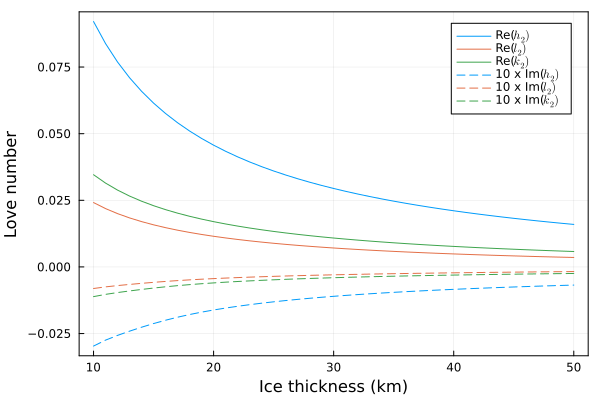

In [13]:
plot(  h_ice/1000,    real(h_enc), color=1, label=L"Re($h_2)", framestyle=:box )
plot!( h_ice/1000,    real(l_enc), color=2, label=L"Re($l_2)" )
plot!( h_ice/1000,    real(k_enc), color=3, label=L"Re($k_2)" )
plot!( h_ice/1000, 10*imag(h_enc), color=1, label=L"10 x Im($h_2)", linestyle=:dash )
plot!( h_ice/1000, 10*imag(l_enc), color=2, label=L"10 x Im($l_2)", linestyle=:dash )
plot!( h_ice/1000, 10*imag(k_enc), color=3, label=L"10 x Im($k_2)", linestyle=:dash )

xlabel!("Ice thickness (km)")
ylabel!("Love number")



### Loading Love Numbers for a transient Earth model

Here I compute loading Love Numbers and their derivatives for the VM5a model.

The $h_n(t)$ LLN is computed for $n=2,10,100$ as a function of time $t$. The standard VM5a model, based on a Maxwell rheology, is compared with transient models in which for the upper mantle a Burgers (VM5a-BG) or Andrade (VM5a-AD) rheology is assumed.

In [14]:
# VM5a Earth model

r   =  [ 3485.5, 5111.0, 5701.0 , 6271.0, 6311.0, 6371.0 ] * 1000 ;
rho =  [ 1.09626e4, 5.10252e3, 4.54824e3, 3.63687e3, 3.37472e3, 3.02751e3] ;
mu  =  [ 0, 2.4446e11, 1.8321e11, 8.9212e10, 6.7446e10, 5.2429e10 ] ;
eta =  [ 0, 3.23e21, 1.57e21, 5e20, 1e22, 1e99 ] ;


In [15]:
# Time steps

t = 10 .^ range(-3,2,length=100);

In [16]:
# Harmonic degrees

n = [2, 10, 100];

In [17]:
# Other parameters

loadtype="loading";
loadfcn="step";
tau=0;
order=8;

In [18]:
# Compute LLN

output="real";

# Maxwell UM

println( "VM5a" );
rheology = [ "fluid", "maxwell", "maxwell", "maxwell", "maxwell", "elastic" ];
par = zeros( length(r),2 );

@time begin
model = build_model(r,rho,mu,eta,rheology,par);
hMX, lMX, kMX = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end

# Burgers UM

println( "VM5a-BG" );
rheology = [ "fluid", "maxwell", "maxwell", "burgers", "burgers", "elastic" ];
par = zeros( length(r),2 );
par[4,:] = [1, 0.1];
par[5,:] = [1, 0.1];

@time begin
model = build_model(r,rho,mu,eta,rheology,par);
hBG, lBG, kBG = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end

# Andrade UM

println( "VM5a-AD" );
rheology = [ "fluid", "maxwell", "maxwell", "andrade", "andrade", "elastic" ];
par = zeros( length(r),2 );
par[4,:] = [0.3, 0];
par[5,:] = [0.3, 0];

@time begin
model = build_model(r,rho,mu,eta,rheology,par);
hAD, lAD, kAD = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end


VM5a


 26.765626 seconds (367.57 M allocations: 21.239 GiB, 23.66% gc time)
VM5a-BG


 24.375066 seconds (367.80 M allocations: 21.253 GiB, 25.14% gc time)
VM5a-AD


 23.919426 seconds (367.86 M allocations: 21.253 GiB, 25.17% gc time)


(BigFloat[-0.4554216467355305870096959148458988786445667754075532886463936990746829337978479052976912192382793304161545522624320451739002024827 -0.4556511475813051786720862211092499201723016512619987509080554675454466845108920497035017260600157219151326805712614393424102037832 … -2.157911643982779465487990050621556946662150986452713903792798533669930735189349473427783354371563922999164944282487229851293692558 -2.168193102502731214653593428284796950110862835048843642832014805183215005660219023812681394654583337623765514316654179767158573027; -0.7930884521290285735061711526339770082618166853464214785773793310622225490070075327958752051160010565973540800952151542886454674121 -0.7959175323728616164229938964628776644248229333373843633010634257303656498180978950225891653757462557418129130987081018993465114006 … -10.35433017219485233957539928128422000599792238393654007225507615113630988388981830348018640188411915757753974010716619058946775089 -10.3781612873661737303573132289367976868327696893

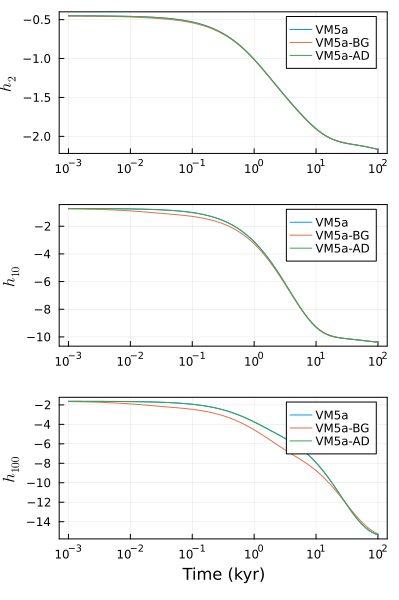

In [19]:
p = Vector{Any}(undef, 3);

for i=1:3
    p[i] = plot( t, hMX[i,:], label="VM5a", xaxis=:log, framestyle=:box, xticks=exp10.(-3:3));
    p[i] = plot!( t, hBG[i,:], label="VM5a-BG" );
    p[i] = plot!( t, hMX[i,:], label="VM5a-AD" );
    p[i] = ylabel!(L"h_{%$(n[i])}")
end
p[3] = xlabel!( p[3], "Time (kyr)")

plot( p... , layout=(3,1), size=(400,600) )


In [20]:
# Compute derivatives of LLN

output="rate";

# Maxwell UM

println( "VM5a" );
rheology = [ "fluid", "maxwell", "maxwell", "maxwell", "maxwell", "elastic" ];
par = zeros( length(r),2 );

@time begin
model = build_model(r,rho,mu,eta,rheology,par);
dhMX, dlMX, dkMX = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end

# Burgers UM

println( "VM5a-BG" );
rheology = [ "fluid", "maxwell", "maxwell", "burgers", "burgers", "elastic" ];
par = zeros( length(r),2 );
par[4,:] = [1, 0.1];
par[5,:] = [1, 0.1];

@time begin
model=build_model(r,rho,mu,eta,rheology,par);
dhBG, dlBG, dkBG = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end

# Andrade UM

println( "VM5a-AD" );
rheology = [ "fluid", "maxwell", "maxwell", "andrade", "andrade", "elastic" ]
par = zeros( length(r),2 )
par[4,:] = [0.3, 0];
par[5,:] = [0.3, 0];

@time begin
model = build_model(r,rho,mu,eta,rheology,par);
dhAD, dlAD, dkAD = love_numbers(model,n,t,loadtype,loadfcn,tau,output,order);
end


VM5a


 22.603899 seconds (367.63 M allocations: 21.243 GiB, 25.66% gc time)
VM5a-BG


 21.667279 seconds (367.86 M allocations: 21.257 GiB, 26.19% gc time)
VM5a-AD


 21.181136 seconds (367.92 M allocations: 21.257 GiB, 26.25% gc time)


(BigFloat[-1.908544480553317235974858616565446877880709343390077617124701596495781734560298063950031452620620333634804115447941753126864067656 -1.816465529370008528075368143344833601953714052239097035426232059899934437120511893472770966810173741250324551780804483191880732931 … -0.0009547285135247117782904819852930539748534711141540673927391951083005804430705879903664472296377537887281002873994915364654560081595 -0.0009168668978017791691279279065521080551622235134005530130962443335331970789853017403225423942218918993482737155039907410181927533534; -23.80287370032195849330631505374461360867030658213876509340231251575507155270022998026985599549039973278498067771476481329618422582 -22.13281217151087384225200524781309746575250732901027036673119033295078978768926470452875874426998767827957521215807612744830950065 … -0.002350908018601106924715407668369291408487076913584175017106064427308416543449934868767527599358089127992116086760473248786599287523 -0.0019876959704390209343501105654620259300

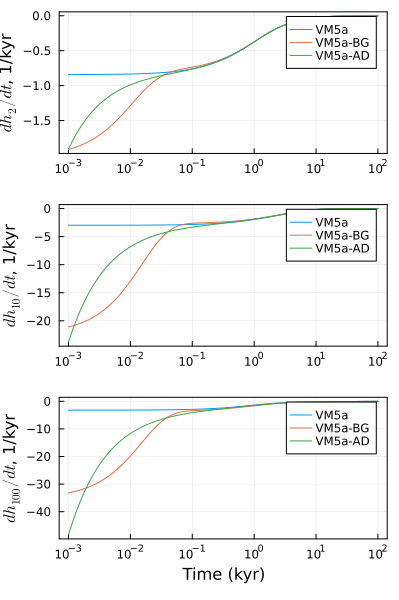

In [21]:
p = Array{Any}(undef, 3)

for i=1:3
    p[i] = plot(t, dhMX[i,:], label="VM5a", xaxis=:log, framestyle=:box, xticks=exp10.(-3:3) );
    p[i] = plot!(t, dhBG[i,:], label="VM5a-BG" );
    p[i] = plot!(t, dhAD[i,:], label="VM5a-AD" );
    p[i] = ylabel!( L"$dh_{%$(n[i])}/dt$, 1/kyr" )
end
p[3] = xlabel!(p[3], "Time (kyr)")

plot( p... , layout=(3,1), size=(400,600) )


### Tidal dissipation of the Moon

In [22]:
using DelimitedFiles

In [23]:
# Load the Weber2011 model

data=readdlm("DATA/Moon_Weber11.dat", skipstart=3);

a     = 1737.1;
depth = data[:,1];
r     = a .- depth;
vp    = data[:,2] * 1000;
vs    = data[:,3] * 1000;
rho   = data[:,4] * 1000;
mu    = rho .* (vs .^ 2);

r_w11   = r[1:2:end];
rho_w11 = rho[1:2:end];
mu_w11  = mu[1:2:end];

r_w11   = reverse( r_w11   );
rho_w11 = reverse( rho_w11 );
mu_w11  = reverse( mu_w11  );


In [24]:
# Load the Garcia2012 model

data=readdlm("DATA/Moon_Garcia12.dat", skipstart=2);

r     = data[:,1];
vp    = data[:,2] * 1000;
vs    = data[:,3] * 1000;
rho   = data[:,4] * 1000;
mu    = rho .* (vs .^ 2);

nla   = length(r);

idx   = vcat( [1,3,5], collect(range(7,nla-3)), nla-1 );

r_g12   = r[idx];
rho_g12 = rho[idx];
mu_g12  = mu[idx];

r_g12   = reverse( r_g12 );
rho_g12 = reverse( rho_g12 );
mu_g12  = reverse( mu_g12 );


In [25]:
# Identify the layers

#0--> Inner core
#1--> Core
#2--> LVZ
#3--> Mantle
#4--> Crust

# For Weber 2011

layertype_w11 = zeros( Int, length(r_w11) );
r=r_w11;
layertype_w11[ (r.<=240)               ] .= 0;
layertype_w11[ (r.>240 ) .& (r.<=330 ) ] .= 1;
layertype_w11[ (r.>330 ) .& (r.<=480 ) ] .= 2;
layertype_w11[ (r.>480 ) .& (r.<=1700) ] .= 3;
layertype_w11[ (r.>1700)               ] .= 4;

# For Garcia 2012

layertype_g12 = zeros( Int, length(r_g12) );

r=r_g12;
layertype_g12[ r.<=380 ]                          .= 1;
layertype_g12[ (r.>380)       .&  (r.<=380+150) ] .= 2;
layertype_g12[ (r.>=380+150)  .&  (r.<1700)     ] .= 3;
layertype_g12[ r.>1700                          ] .= 4;



In [26]:
# Define the rheology and viscosity for each layer class

rheology = [  "maxwell", "newton", "maxwell", "maxwell", "maxwell" ];
eta      = [   1e16, 1e4, -1, 1e20, 1e20 ];

# -1 is a placeholder for the LVZ viscosity which will be varied 

5-element Vector{Float64}:
     1.0e16
 10000.0
    -1.0
     1.0e20
     1.0e20

In [27]:
reol_w11 = String[];
eta_w11  = zeros(length(r_w11));

for i=1:length(r_w11)
    itype = layertype_w11[i] + 1;
    push!(reol_w11, rheology[itype]);
    eta_w11[i] = eta[itype];
end
reol_g12 = String[];
eta_g12  = zeros(length(r_g12));

for i=1:length(r_g12)
    itype = layertype_g12[i] + 1;
    push!(reol_g12, rheology[itype]);
    eta_g12[i] = eta[itype]; 
end

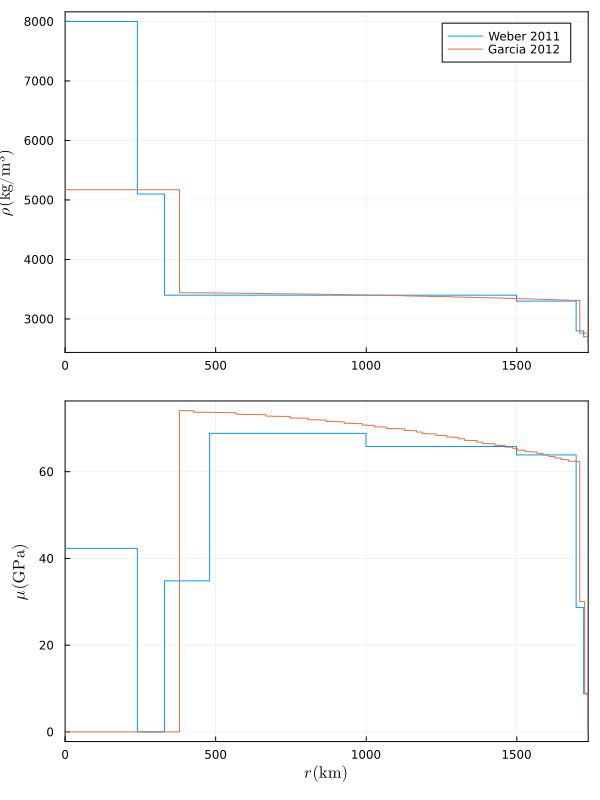

In [28]:

p1 = plot(  vcat(0,r_w11), vcat(rho_w11[1], rho_w11), linetype=:steppre, label="Weber 2011", framestyle=:box );
p1 = plot!( vcat(0,r_g12), vcat(rho_g12[1], rho_g12), linetype=:steppre, label="Garcia 2012" );
p1 = ylabel!(L"$\rho\, \mathrm{(kg/m^3)}$");
p1 = xlims!(0,1737.1)

p2 = plot(  vcat(0,r_w11), vcat(mu_w11[1], mu_w11) / 1e9, linetype=:steppre, label="", framestyle=:box );
p2 = plot!( vcat(0,r_g12), vcat(mu_g12[1], mu_g12) / 1e9, linetype=:steppre, label="" );
p2 = ylabel!(L"$\mu\, \mathrm{(GPa)}$");
p2 = xlabel!(L"r\, \mathrm{(km)}");
p2 = xlims!(0,1737.1)

plot( p1, p2 , layout=(2,1), size=(600,800) )


In [29]:
# Range of LVZ viscosities

log_eta_lvz = 14:0.05:18;

In [30]:
# Forcing period

t = 27.212;     # days
t = t / (365.25 * 1000);   #kyr

In [31]:
# ALMA parameters

n = 2;
loadtype="tidal";
loadfcn="step";
tau=0;
output="complex";
order=8;


In [32]:
# Weber2011-based models

kw11 = zeros( Complex, length(log_eta_lvz) );
par  = zeros( length(r_w11), 2 );

@time begin

for i=1:length(log_eta_lvz)

    eta_lvz = 10 ^ log_eta_lvz[i];
    visco   = copy(eta_w11);
    visco[eta_w11 .< 0] .= eta_lvz;
    
    model = build_model(r_w11*1000,rho_w11,mu_w11,visco,reol_w11,par);
    hh, ll, kk = love_numbers(model,[n],[t],loadtype,loadfcn,tau,output,order);
    
    kw11[i] = kk[1,1];

end

end


  0.959989 seconds (11.88 M allocations: 700.451 MiB, 17.81% gc time, 15.79% compilation time)


In [33]:

# Garcia2012-based models

kg12 = zeros( Complex, length(log_eta_lvz) );
par  = zeros( length(r_g12), 2 );

@time begin

    for i=1:length(log_eta_lvz)
    
        eta_lvz = 10 ^ log_eta_lvz[i];
        visco   = copy(eta_g12);
        visco[eta_g12 .< 0] .= eta_lvz;
        
        model = build_model(r_g12*1000,rho_g12,mu_g12,visco,reol_g12,par);
        hh, ll, kk = love_numbers(model,[n],[t],loadtype,loadfcn,tau,output,order);
        
        kg12[i] = kk[1,1];

    end
    
end

  5.946801 seconds (88.64 M allocations: 5.139 GiB, 22.04% gc time)


In [45]:
k2abs_w11 = abs.(kw11);
phi_w11   = -atand.(imag.(kw11)./real.(kw11));
q_w11     = 1 ./sind.(phi_w11);

k2abs_g12 = abs.(kg12);
phi_g12   = -atand.(imag.(kg12)./real.(kg12));
q_g12     = 1 ./sind.(phi_g12);


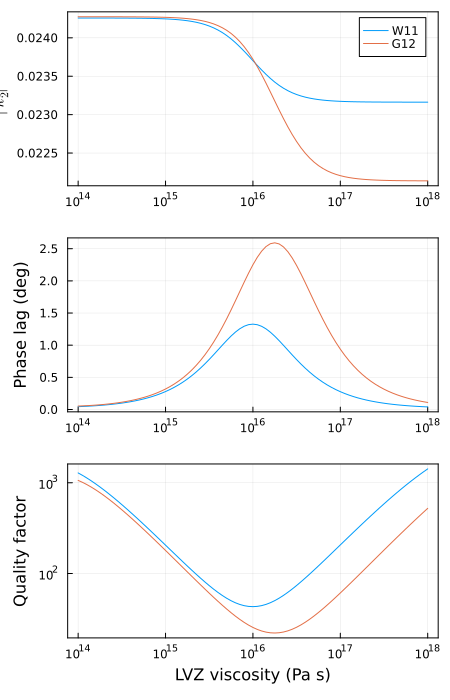

In [46]:

p1 = plot(  10 .^log_eta_lvz, k2abs_w11, label="W11", framestyle=:box, xaxis=:log );
p1 = plot!( 10 .^log_eta_lvz, k2abs_g12, label="G12" );
p1 = ylabel!(L"|k_2|")

p2 = plot(  10 .^log_eta_lvz, phi_w11, label="", framestyle=:box, xaxis=:log );
p2 = plot!( 10 .^log_eta_lvz, phi_g12, label="" );
p2 = ylabel!("Phase lag (deg)")

p3 = plot(  10 .^log_eta_lvz, q_w11, label="", framestyle=:box, xaxis=:log, yaxis=:log );
p3 = plot!( 10 .^log_eta_lvz, q_g12, label="" );
p3 = ylabel!("Quality factor")
p3 = xlabel!("LVZ viscosity (Pa s)")

plot( p1, p2, p3, layout=(3,1), size=(450,700) )



